# 0. 사전 준비

먼저 주요 라이브러리 버전부터 확인해 봅시다!!

In [1]:
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

print(tf.__version__)

2.8.2


그리고 나서 조금 전에 다운 받았던 KITTI를 해당 노트에서도 똑같이 다운로드를 해야 합니다.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DATA_PATH = '/content/drive/MyDrive/AIFFEL/DATASET/GoingDeeper/06'

(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

다운로드한 KITTI 데이터셋을 tfds.show_examples를 통해 확인해 봅니다.

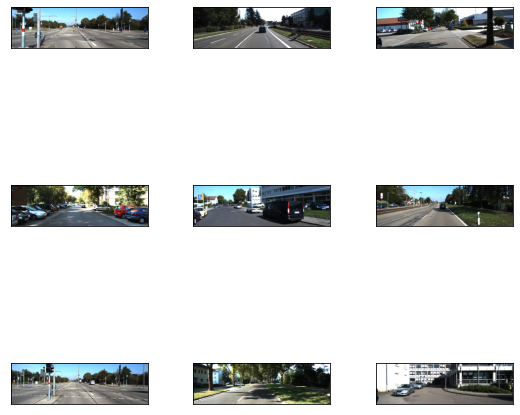

In [4]:
_ = tfds.show_examples(ds_train, ds_info)

------Example------
['image', 'image/file_name', 'objects']
------Objects------
{'alpha': <tf.Tensor: shape=(13,), dtype=float32, numpy=
array([ 2.69, -0.71, -0.67, -0.6 ,  1.7 ,  1.67, -0.28, -2.02, -1.99,
       -2.07,  1.77,  1.43, -1.47], dtype=float32)>, 'bbox': <tf.Tensor: shape=(13, 4), dtype=float32, numpy=
array([[0.32130668, 0.61653787, 0.59472   , 0.8512238 ],
       [0.49936   , 0.89769727, 0.6104    , 0.99919486],
       [0.49768   , 0.8665459 , 0.6007467 , 0.97438   ],
       [0.49890667, 0.83538646, 0.60058665, 0.94057167],
       [0.36674666, 0.3224396 , 0.51496   , 0.38299516],
       [0.39765334, 0.3996538 , 0.52408   , 0.44914654],
       [0.47498667, 0.62198067, 0.59592   , 0.71836555],
       [0.50434667, 0.73455715, 0.59224   , 0.7820531 ],
       [0.51717335, 0.8176731 , 0.62032   , 0.87296295],
       [0.50901335, 0.76338166, 0.58882666, 0.816409  ],
       [0.39818665, 0.35066023, 0.5114933 , 0.4028261 ],
       [0.45842665, 0.51618356, 0.53349334, 0.54922706],

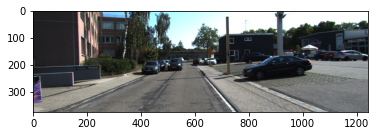

In [5]:
sample = ds_train.take(1)

for example in sample:
  print('------Example------')
  print(list(example.keys()))
  image = example["image"]
  filename = example["image/file_name"].numpy().decode('utf-8')
  objects = example["objects"]

print('------Objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

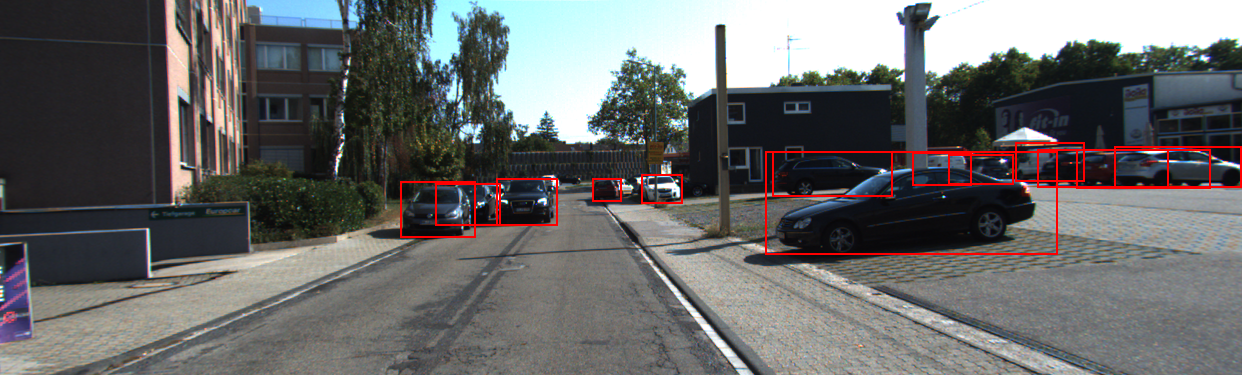

In [6]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
      draw.rectangle(_rect, outline=(255,0,0), width=2)

    return input_image

visualize_bbox(img, objects['bbox'].numpy())



```
데이터셋 이해를 위한 예시
Values    Name      Description
----------------------------------------------------------------------------
   1    type         Describes the type of object: 'Car', 'Van', 'Truck',
                     'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram',
                     'Misc' or 'DontCare'
   1    truncated    Float from 0 (non-truncated) to 1 (truncated), where
                     truncated refers to the object leaving image boundaries
   1    occluded     Integer (0,1,2,3) indicating occlusion state:
                     0 = fully visible, 1 = partly occluded
                     2 = largely occluded, 3 = unknown
   1    alpha        Observation angle of object, ranging [-pi..pi]
   4    bbox         2D bounding box of object in the image (0-based index):
                     contains left, top, right, bottom pixel coordinates
   3    dimensions   3D object dimensions: height, width, length (in meters)
   3    location     3D object location x,y,z in camera coordinates (in meters)
   1    rotation_y   Rotation ry around Y-axis in camera coordinates [-pi..pi]
   1    score        Only for results: Float, indicating confidence in
                     detection, needed for p/r curves, higher is better.
```





# 1. 데이터 준비

해당 데이터셋을 학습에 맞는 형태로 바꿔줘야 합니다. 총 4단계로 이뤄져 있습니다.

1. x와 y좌표의 위치 교체  
2. 무작위로 수평 뒤집기(flip)
3. 이미지 크기 조정 및 패딩 추가
4. 좌표계를 [x_min, y_min, width, height]로 수정

In [7]:
def swap_xy(boxes):
  return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

In [8]:
def random_flip_horizontal(image, boxes):
  if tf.random.uniform(()) > 0.5:
    image = tf.image.flip_left_right(image)
    boxes = tf.stack(
        [1 - boxes[:, 2], boxes[:, 1], 1- boxes[:, 0], boxes[:, 3]], axis=-1
    )
  return image, boxes

이미지의 비율이 유지가 되어야 하고, 이미지의 최대/최소 크기도 제한해야 합니다.

In [9]:
def resize_and_pad_image(image, training=True):

  min_side = 800.0
  max_side = 1333.0
  min_side_range = [640, 1024]
  stride = 128.0

  image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
  if training:
    min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
  ratio = min_side / tf.reduce_min(image_shape)

  if ratio * tf.reduce_max(image_shape) > max_side:
    ratio = max_side / tf.reduce_max(image_shape)
  image_shape = ratio * image_shape
  image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
  padded_image_shape = tf.cast(
      tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
  )
  image = tf.image.pad_to_bounding_box(
      image, 0, 0, padded_image_shape[0], padded_image_shape[1]
  )
  return image, image_shape, ratio

In [10]:
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

In [11]:
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

# 2. 인코딩

One stage detector에서는 Anchor Box를 통해 물체의 위치를 결정 짓습니다. Anchor Box가 생성되어 있는 부분이 바로 물체 위치 후보인 셈입니다.

In [12]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1/3, 2/3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

데이터 원본의 bbox는 주관식 정답입니다. 하지만 모델은 객관식으로 문제를 풀어야 합니다. 따라서 가장 정답과 가까운 객관식 정답으로 바꿔줘야 모델이 학습할 수 있습니다. 이 때 IoU를 사용합니다.

[IoU의 정의](https://ballentain.tistory.com/12)


In [13]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

실제 라벨을 Anchor Box에 맞추는 클래스를 만듭니다. 그 안에는 `compute_iou`를 이용해 IoU를 구하고, 기준에 맞는 물체에 해당되는 Anchor Box를 지정하는 내용을 담은 함수를 구현합니다.

In [14]:
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()

# 3. 모델 작성

RetinaNet에서는 FPN(Feature Pyramid Network)를 사용합니다.

In [15]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

`buid_head`라는 함수를 만드는 과정입니다. 

In [16]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

RetinaNet의 backbone은 ResNet50이라고 합니다. FPN에 이용할 수 있도록 중간 레이어도 output으로 연결합니다.

In [17]:
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

RetinaNet을 완성할 수 있도록 하는 클래스를 생성합니다. Backbone + FPN + classification용 head와 box용 head입니다.

In [18]:
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

모델이 준비 완료됐으니, 이제 Loss에 대해서도 준비해야 합니다.

In [19]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

# 4. 모델 학습

앞에서 만들어 놓은 클래스와 함수를 이용해서 모델을 조립하고 학습합니다.

In [20]:
num_classes = 8
batch_size = 2

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

94781440/94765736 [==============================] - 1s 0us/step


In [21]:
# learning rate 조정
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
# Optimizer는 동일하게 SGD를 사용
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

In [22]:
label_encoder = LabelEncoder()
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)

In [23]:
model_dir = '/content/drive/MyDrive/AIFFEL/DATASET/GoingDeeper/06/checkpoint'
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]

epochs = 1

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks_list
)

3173/3173 [==============================] - ETA: 0s - loss: 2.1785
Epoch 1: saving model to /content/drive/MyDrive/AIFFEL/DATASET/GoingDeeper/06/checkpoint/weights_epoch_1
3173/3173 [==============================] - 1649s 511ms/step - loss: 2.1785 - val_loss: 1.4611


# 5. 결과 확인 및 추론

[tf.image.combined_non_max_suppression](https://www.tensorflow.org/api_docs/python/tf/image/combined_non_max_suppression)

위 참고자료를 꼭 읽어보세요. 입출력되는 값이 어떤지 알아야 코드가 이해가 됩니다.

In [24]:
# 학습한 모델 불러오기
model_dir = '/content/drive/MyDrive/AIFFEL/DATASET/GoingDeeper/06/checkpoint'
latest_checkpoint = tf.train.latest_checkpoint(model_dir)
model.load_weights(latest_checkpoint)

In [25]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

In [26]:
image = tf.keras.Input(shape=[None, None, 3], name='image')
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

In [27]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2 # matplitlib에서 Rectangle와 text를 그릴 때는 좌하단이 원점이고 위로 갈 수록 y값이 커집니다
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

In [28]:
def prepare_image(image):
  image, _, ratio = resize_and_pad_image(image, training=False)
  image = tf.keras.applications.resnet.preprocess_input(image)
  return tf.expand_dims(image, axis=0), ratio

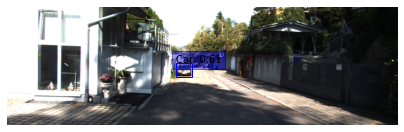

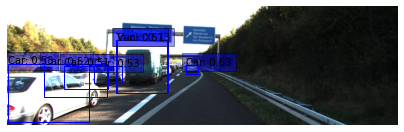

In [29]:
test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
int2str = dataset_info.features["objects"]["type"].int2str

for sample in test_dataset.take(2):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

# 6. 자율주행 시스템 만들기

지금까지 만들어 온 모델을 통해 아래의 조건을 만족하는 함수를 만들어 주세요!!

1. 입력으로 이미지 경로를 받습니다.
2. 정지 조건에 맞는 경우 "Stop", 아닌 경우 "Go"를 반환합니다.
3. 정지 조건은 다음과 같습니다.

* 사람이 한 명 이상 있는 경우
* 차량의 크기(width or height)가 300px 이상인 경우

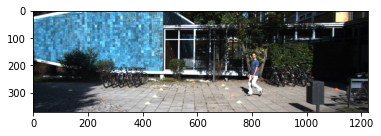

In [46]:
img_path = '/content/drive/MyDrive/AIFFEL/DATASET/GoingDeeper/06/image/stop_1.png'

image = Image.open(img_path)
image = np.array(image)
plt.imshow(image)
plt.show()

In [47]:
import cv2

def self_drive_assist(model,img_path, size_limit=300, visualize=True):
    image = cv2.imread(img_path) # 이미지 읽기
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.asarray(image)

    input_tensor = tf.convert_to_tensor(image, dtype=tf.float32) # 텐서
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

        # 만약 사람이 1명 이상이면 멈춘다.
    if class_names.count('Pedestrian') >= 1 :
        return "Stop"
        
    for box in detections.nmsed_boxes[0][:num_detections] : 
        x1, y1, x2, y2 = box
        w = (x2-x1) * ratio 
        h = (y2-y1) * ratio

        print(w,h,ratio)
      
        # 사람이 아닌 경우 width와 height 둘 중 하나가 300 이상이면 'Stop'
        if size_limit <= w or size_limit <= h :
            return "Stop"

    # 둘다 아니라면 그냥 간다. 
    else: 
        return "Go"

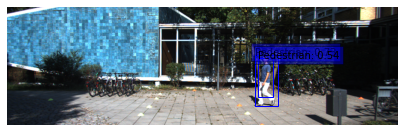

Stop


In [49]:
img_path = '/content/drive/MyDrive/AIFFEL/DATASET/GoingDeeper/06/image/stop_1.png'
print(self_drive_assist(model, img_path))

In [56]:
import os

def test_system(func):
    work_dir = '/content/drive/MyDrive/AIFFEL/DATASET/GoingDeeper/06/image'
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = self_drive_assist(model=model, img_path=image_path)
        print(image_file)
        print(f'prediction: {pred}, answer: {answer}\n')
        if pred == answer:
            score += 10
    print(f"결과: {score}점입니다.")

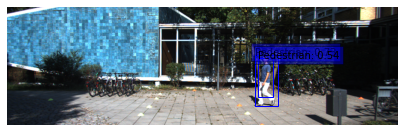

stop_1.png
prediction: Stop, answer: Stop



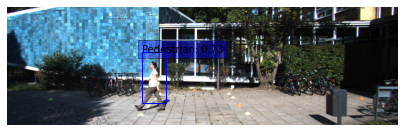

stop_2.png
prediction: Stop, answer: Stop



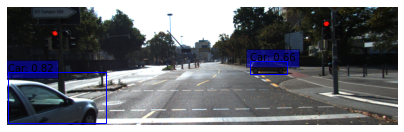

tf.Tensor(362.12912, shape=(), dtype=float32) tf.Tensor(190.51634, shape=(), dtype=float32) tf.Tensor(1.0890523, shape=(), dtype=float32)
stop_3.png
prediction: Stop, answer: Stop



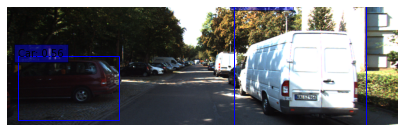

tf.Tensor(481.09912, shape=(), dtype=float32) tf.Tensor(475.16602, shape=(), dtype=float32) tf.Tensor(1.0732689, shape=(), dtype=float32)
stop_4.png
prediction: Stop, answer: Stop



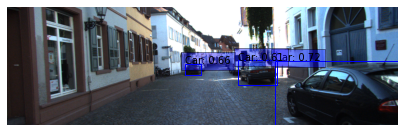

tf.Tensor(459.97144, shape=(), dtype=float32) tf.Tensor(238.47064, shape=(), dtype=float32) tf.Tensor(1.0732689, shape=(), dtype=float32)
stop_5.png
prediction: Stop, answer: Stop



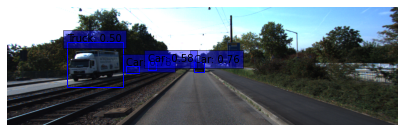

tf.Tensor(46.796135, shape=(), dtype=float32) tf.Tensor(25.554104, shape=(), dtype=float32) tf.Tensor(1.0732689, shape=(), dtype=float32)
tf.Tensor(39.236546, shape=(), dtype=float32) tf.Tensor(34.522488, shape=(), dtype=float32) tf.Tensor(1.0732689, shape=(), dtype=float32)
tf.Tensor(32.161972, shape=(), dtype=float32) tf.Tensor(29.01157, shape=(), dtype=float32) tf.Tensor(1.0732689, shape=(), dtype=float32)
tf.Tensor(203.05122, shape=(), dtype=float32) tf.Tensor(166.64677, shape=(), dtype=float32) tf.Tensor(1.0732689, shape=(), dtype=float32)
go_1.png
prediction: Go, answer: Go



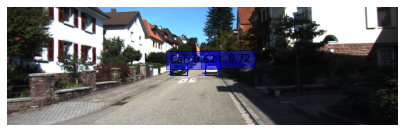

tf.Tensor(47.12046, shape=(), dtype=float32) tf.Tensor(47.97225, shape=(), dtype=float32) tf.Tensor(1.0732689, shape=(), dtype=float32)
tf.Tensor(62.184612, shape=(), dtype=float32) tf.Tensor(42.747925, shape=(), dtype=float32) tf.Tensor(1.0732689, shape=(), dtype=float32)
go_2.png
prediction: Go, answer: Go



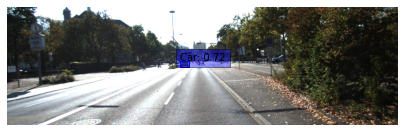

tf.Tensor(33.609203, shape=(), dtype=float32) tf.Tensor(23.919601, shape=(), dtype=float32) tf.Tensor(1.0890523, shape=(), dtype=float32)
go_3.png
prediction: Go, answer: Go



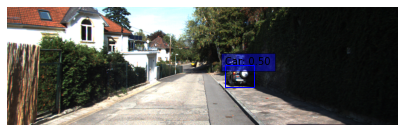

tf.Tensor(103.837585, shape=(), dtype=float32) tf.Tensor(83.57832, shape=(), dtype=float32) tf.Tensor(1.0732689, shape=(), dtype=float32)
go_4.png
prediction: Go, answer: Go



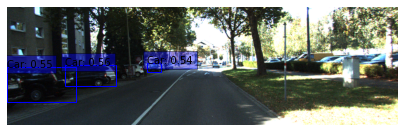

tf.Tensor(188.25934, shape=(), dtype=float32) tf.Tensor(75.72654, shape=(), dtype=float32) tf.Tensor(1.0732689, shape=(), dtype=float32)
tf.Tensor(254.769, shape=(), dtype=float32) tf.Tensor(127.02675, shape=(), dtype=float32) tf.Tensor(1.0732689, shape=(), dtype=float32)
tf.Tensor(51.23847, shape=(), dtype=float32) tf.Tensor(30.877804, shape=(), dtype=float32) tf.Tensor(1.0732689, shape=(), dtype=float32)
go_5.png
prediction: Go, answer: Go

결과: 100점입니다.


In [57]:
test_system(self_drive_assist)

# ✍ 루브릭

|평가문항|상세기준|결과|
|------|------|:------:|
|1. KITTI 데이터셋에 대한 분석이 체계적으로 진행되었다.|KITTI 데이터셋 구조와 내용을 파악하고 이를 토대로 필요한 데이터셋 가공을 정상 진행하였다.|O|
|2. RetinaNet 학습이 정상적으로 진행되어 object detection 결과의 시각화까지 진행되었다.|바운딩박스가 정확히 표시된 시각화된 이미지를 생성하였다.|O|
|3. 자율주행 Object Detection 테스트 시스템 적용결과 만족스러운 정확도 성능을 달성했다.|테스트 수행결과 90% 이상의 정확도를 보였다.|O|


# 회고

* 일단 다른 거 다 떠나서 개념이 다소 생소하고 어렵게 다가왔다. 모델을 구성하는 일련의 과정 하나하나에 숨어있는 개념들이 이해하기 상당히 까다로워서 따라오기가 벅찬 프로젝트였던 거 같았다.

* 특히 아래 구문에서처럼 사람이 아닌 경우 너비 혹은 높이 둘 중 하나가 300 이상일 때 Stop을 하는 구문이 왜 저렇게 구성이 되어야 하는지를 몰랐다. ㅠㅠ

```
    for box in detections.nmsed_boxes[0][:num_detections] : 
        x1, y1, x2, y2 = box
        w = (x2-x1) * ratio 
        h = (y2-y1) * ratio

        print(w,h,ratio)
      
        # 사람이 아닌 경우 width와 height 둘 중 하나가 300 이상이면 'Stop'
        if size_limit <= w or size_limit <= h :
            return "Stop"
```


* 이렇듯 적은 이해도를 가지고 코드를 필사하기만 하는 학습 방법의 한계를 체감할 수 있었던 노드였다. 여러 모로 어렵게 다가왔던 노드였지만 한편으로는 어떤 식으로 학습해야 할지를 일깨워주었던 나름의 교훈을 얻을 수 있었다.